In [10]:
import itertools
import logging
import simpy
import numpy as np

from dataclasses import dataclass, field
from collections import defaultdict, namedtuple, Counter

from typing import List

import seaborn as sns
sns.set_style("whitegrid")

from matplotlib import pyplot as plt
import pandas as pd

from sim_tools.distributions import Exponential

In [11]:
# Logging config

class SimTimeFilter:
    def __init__(self, env):
        self.env = env

    def filter(self, record):
        record.sim_time = self.env.now
        return True


def setup_logger(env, level = logging.INFO):
    logger = logging.getLogger()
    logger.setLevel(level)

    # Looks like iPython already starts with handlers...
    logger.handlers.clear()

    handler = logging.StreamHandler()
    formatter = logging.Formatter("%(levelname)s - %(sim_time).2f - %(message)s")

    handler.setFormatter(formatter)

    logger.addHandler(handler)
    # Abuse the filter to add new information to the log record (sim_time)
    logger.addFilter(SimTimeFilter(env))

    return logger



In [12]:
SEED = 42

EMERGENCY_MEAN_IAT = 10
EMERGENCY_SURGICAL_DURATION = 3
EMERGENCY_MEAN_RECOVERY_TIME = 60

ELECTIVE_MEAN_IAT = 16
ELECTIVE_SURGICAL_DURATION = 2
ELECTIVE_MEAN_RECOVERY_TIME = 48

RUN_LENGTH = 480
NUM_BEDS = 10
NUM_CC_BEDS = 2

DAILY = 24
WEEKLY = 7 * DAILY

INITIAL_NUMBER_OF_ELECTIVE = 3
INITIAL_NUMBER_OF_EMERGENCY = 1

MAX_EMERGENCY_WAIT = 48


class Experiment:
    def __init__(
            self, 
            seed = SEED, 
            initial_number_of_elective = INITIAL_NUMBER_OF_ELECTIVE,
            initial_number_of_emergency = INITIAL_NUMBER_OF_EMERGENCY,
            elective_mean_iat = ELECTIVE_MEAN_IAT,
            emergency_mean_iat = EMERGENCY_MEAN_IAT, 
            elective_surgical_duration = ELECTIVE_SURGICAL_DURATION,
            emergency_surgical_duration = EMERGENCY_SURGICAL_DURATION, 
            elective_mean_recovery_time = ELECTIVE_MEAN_RECOVERY_TIME,
            emergency_mean_recovery_time = EMERGENCY_MEAN_RECOVERY_TIME,
            max_emergency_wait = MAX_EMERGENCY_WAIT
        ):
        self.patients = []

        self.initial_number_of_elective = initial_number_of_elective
        self.initial_number_of_emergency = initial_number_of_emergency

        seeds = np.random.SeedSequence(seed).spawn(6)

        self.emergency_arrival_dist = Exponential(
            emergency_mean_iat, random_seed=seeds[0]
        )
        self.elective_arrival_dist = Exponential(
            elective_mean_iat, random_seed=seeds[1]
        )
        
        self.elective_surgical_duration_dist = Exponential(
            elective_surgical_duration, random_seed=seeds[2]
        )
        self.emergency_surgical_duration_dist = Exponential(
            emergency_surgical_duration, random_seed=seeds[3]
        )

        self.elective_recovery_time_dist = Exponential(
            elective_mean_recovery_time, random_seed=seeds[4]
        )
        self.emergency_recovery_time_dist = Exponential(
            emergency_mean_recovery_time, random_seed=seeds[5]
        )

        self.max_emergency_wait = MAX_EMERGENCY_WAIT

        


@dataclass
class Patient:
    id: str
    arrival_time: int = None
    surgical_time: int = None 
    discharge_time: int = None
    surgery_duration: int = None
    recovery_time: int = None
    cancellations: List = field(default_factory=lambda : [])

In [13]:
# Theatre
def surgery(env, beds, cc_beds, patients, hours_available, schedule, experiment, metrics):
    end_time = env.now + hours_available

    metrics["beds"].append((env.now, beds.count))
    for patient in patients:
        timeout = env.timeout(max(0, end_time - env.now - patient.surgery_duration))

        cc_bed_req = cc_beds.request()
        result = yield env.any_of([cc_bed_req, timeout])
        logger.info(f"Requesting cc bed for patient {patient}")

        if cc_bed_req in result:
            metrics["beds"].append((env.now, beds.count))

            logger.info(f"Assigned cc bed to {patient}")
            metrics["cc_bed_event"].append((env.now, 1))

            bed_req = beds.request()
            
            logger.info(f"Requesting bed for patient {patient}")
            timeout = env.timeout(max(0, end_time - env.now - patient.surgery_duration))
            result = yield env.any_of([bed_req, timeout])

            if bed_req in result:
                metrics["beds"].append((env.now, beds.count))

                logger.info(f"Assigned bed to {patient}")
                metrics["bed_event"].append((env.now, 1))

                surgical_time = env.now
                metrics["surgical_event"].append((surgical_time, 1))
                
                patient.surgical_time = surgical_time

                yield env.timeout(patient.surgery_duration)
                logger.info(f"{patient.id} had surgery for: {patient.surgery_duration} hours")
                metrics["surgical_event"].append((env.now, -1))

                # TODO: random select if patient goes to CC (what to do with bed until then?)
                cc_beds.release(cc_bed_req)
                metrics["cc_bed_event"].append((env.now, -1))

                env.process(ward(env, beds, bed_req, patient, metrics))

                metrics["beds"].append((env.now, beds.count))

            else:
                logger.info(f"{patient.id} cancelled, beds at {beds.count}, hours remaining: {end_time - env.now}, surgical duration: {patient.surgery_duration}")
                schedule.schedule_patients([patient], env.now)

                cc_beds.release(cc_bed_req)
                metrics["cc_bed_event"].append((env.now, -1))

                patient.cancellations.append(env.now)

                bed_req.cancel()

               
        else:
            logger.info(f"{patient.id} cancelled, cc beds at {cc_beds.count}, hours remaining: {end_time - env.now}, surgical duration: {patient.surgery_duration}")
            schedule.schedule_patients([patient], env.now)

            patient.cancellations.append(env.now)

            cc_bed_req.cancel()


def ward(env, beds, bed_req, patient, metrics):
    yield env.timeout(patient.recovery_time)
    beds.release(bed_req)

    metrics["bed_event"].append((env.now, -1))
    metrics["beds"].append((env.now, beds.count))

    patient.discharge_time = env.now
    logger.info(f"{patient.id} discharged, beds now at: {beds.count}, {beds.users}.")
    
    

In [49]:
def scheduler(env, beds, cc_beds, experiment, schedule, metrics):
    while True:
        logging.info(f"stuff: {schedule[env.now]}")
        if len(booked_appts:= schedule[env.now]) != 0:
            for _, scheduled_theatres in booked_appts.iterrows():
                logging.info(f"Sending {scheduled_theatres.patient_type}: {scheduled_theatres.patients} to surgery.")
                env.process(surgery(env, beds, cc_beds, scheduled_theatres.patients, scheduled_theatres.hours_total, schedule, experiment, metrics))

        yield env.timeout(1)


In [50]:
# TODO: This could be a template?

def emergency_generator(env, experiment, schedule, prefix="Emergency"):
    for patient_count in itertools.count(start=1):
        inter_arrival_time = experiment.emergency_arrival_dist.sample()
        
        yield env.timeout(inter_arrival_time)
        
        p = Patient(f"{prefix}{patient_count}", arrival_time=env.now, surgery_duration=experiment.emergency_surgical_duration_dist.sample(), recovery_time=experiment.emergency_recovery_time_dist.sample())
        experiment.patients.append(p)

        logger.info(f"{env.now:.2f}: {p.id} referral arrives.")

        schedule.schedule_patients([p], env.now)

def elective_generator(env, experiment, schedule, prefix="Elective"):
    for patient_count in itertools.count(start=1):
        inter_arrival_time = experiment.emergency_arrival_dist.sample() # TODO: change this for elective
        
        yield env.timeout(inter_arrival_time)
        
        # TODO: change this for elective
        p = Patient(f"{prefix}{patient_count}", arrival_time=env.now, surgery_duration=experiment.elective_surgical_duration_dist.sample(), recovery_time=experiment.elective_recovery_time_dist.sample())
        experiment.patients.append(p)

        logger.info(f"{env.now:.2f}: {p.id} referral arrives.")

        schedule.schedule_patients([p], env.now)

def initial_elective_generator(env, experiment, schedule, prefix="Elective"):
    for patient_count in range(-experiment.initial_number_of_elective, 0):
        p = Patient(f"{prefix}{patient_count}", arrival_time=env.now, surgery_duration=experiment.elective_surgical_duration_dist.sample(), recovery_time=experiment.elective_recovery_time_dist.sample())
        experiment.patients.append(p)

        logger.info(f"{env.now:.2f}: {p.id} referral arrives.")

        schedule.schedule_patients([p], env.now)

def initial_emergency_generator(env, experiment, schedule, prefix="Emergency"):
    for patient_count in range(-experiment.initial_number_of_emergency, 0):
        p = Patient(f"{prefix}{patient_count}", arrival_time=env.now, surgery_duration=experiment.emergency_surgical_duration_dist.sample(), recovery_time=experiment.emergency_recovery_time_dist.sample())
        experiment.patients.append(p)

        logger.info(f"{env.now:.2f}: {p.id} referral arrives.")

        schedule.schedule_patients([p], env.now)


# TODO: As patients are generated, add to schedule?
        # What about emergency?
        # What happens if a scheduled surgery doesn't have a bed available??


In [51]:
class Schedule:
    def __init__(self, slots):
        self.__schedule = defaultdict(lambda : [])
        self.lcm = None

        self.__process_slots(slots)

        self.processed_schedule = self.__process_schedule(self.__schedule)

    def __process_slots(self, slots):
        repeat_periods = [slot.repeat_period for slot in slots]
        self.lcm = np.lcm.reduce(repeat_periods)

        for slot in slots:
            repeat_slots = itertools.repeat(slot.start_time, self.lcm//slot.repeat_period)
            for multiplicative, start_time in enumerate(repeat_slots):

                processed_time = multiplicative * slot.repeat_period + start_time

                self.__schedule[processed_time] += [{slot.patient_type:slot.end_time - slot.start_time}]

        self.__schedule = dict(sorted(self.__schedule.items()))

    def __getitem__(self, time):
        while time > max(self.__schedule):
            multiple = max(self.__schedule) // self.lcm + 1
            later_schedule = {k+(self.lcm*multiple): v for k,v in self.__schedule.items()}
            self.__schedule |= later_schedule

            df = self.__process_schedule(later_schedule)
            self.processed_schedule = pd.concat([self.processed_schedule, df]).reset_index(drop=True)
            
        return self.processed_schedule.loc[(self.processed_schedule["hour"] == time), :]
    
    def __process_schedule(self, schedule):
        df = pd.DataFrame(
            [
                [time, list(slot.keys())[0], list(slot.values())[0], list(slot.values())[0], []
            ] for time, slots in schedule.items() for slot in slots],
            columns = ["hour", "patient_type", "hours_total", "hours_remaining", "patients"]
        )
        return df

    def schedule_patients(self, patients, time):
        patient_types = self.processed_schedule["patient_type"].unique()
        for patient in patients:
            patient_type = patient_types[np.where([patient_type in patient.id for patient_type in patient_types])[0]][0]

            sub_df = self.__find_slot(patient_type, patient, time)

            # if nothing matches in the schedule currently
            if len(sub_df) == 0:
                max_val = max(self.__schedule)
                self[max_val + 1]

                sub_df = self.__find_slot(patient_type, patient, time)

                if len(sub_df) == 0:
                    raise ValueError(f"Surgery duration for patient {patient.id} is too long for any surgery slot with a duration of {patient.surgery_duration}.")

            row_mask = self.processed_schedule.index == sub_df.index[0]
            self.processed_schedule.loc[row_mask, "hours_remaining"] -= patient.surgery_duration
            self.processed_schedule.loc[row_mask, "patients"].values[0].append(patient)

    def __find_slot(self, patient_type, patient, time):
        return self.processed_schedule.loc[
            (self.processed_schedule["patient_type"] == patient_type) 
            & (self.processed_schedule["hours_remaining"] > patient.surgery_duration)
            & (time < self.processed_schedule["hour"])
        ]
    
    def find_patient(self, patient):
        return self.processed_schedule.loc[self.processed_schedule["patients"].apply(lambda r: patient in r), :]

    def cancel_patient(self, patient):
        p_df = self.find_patient(patient).patients.to_list()[0]

        idx = p_df.index(patient)
        p_df.pop(idx)


slot = namedtuple("surgery_slot", ["start_time", "end_time", "patient_type", "repeat_period"])


In [52]:
# TODO:
# - Paramaterise sim from data
#   - dist for emerg arrivals
#   - dist for surgery duration of emerg patients
#   - dist for recovery time of emerg patients
#   - likelihood of going to CC
#   - dist for CC duration

#   - dist for elec arrivals
#   - dist for surgery duration of elec patients
#   - dist for recovery time of elec patients
#   - likelihood of going to CC
#   - dist for CC duration


# - prepopulate simulation
# - Need to make sure discharges happen during the day...


In [53]:
def daily_planning(env, beds, schedule, experiment):
    while True:
        logger.info("New day!!!")
        logger.info(f"{beds.count} beds used, {beds.users}")

        emergency_patients = [
            patient for patient in experiment.patients 
            if "Emergency" in patient.id 
            and patient.surgical_time is None
            and (env.now - patient.arrival_time + 24) > experiment.max_emergency_wait
        ]
        
        emergencies_scheduled = schedule.processed_schedule.loc[
            (schedule.processed_schedule["hour"] >= env.now)
            & (schedule.processed_schedule["hour"] < env.now+24)
            & (schedule.processed_schedule["patient_type"] == "Emergency"), 
            "patients"
        ].values

        emergencies_scheduled = [*itertools.chain.from_iterable(emergencies_scheduled)]

        emergency_patients_breaching = [patient for patient in emergency_patients if patient not in emergencies_scheduled]
        logger.info(f"{len(emergency_patients_breaching)} patients are breaching! {emergency_patients_breaching}")

        non_emergencies_scheduled = schedule.processed_schedule.loc[
            (schedule.processed_schedule["hour"] >= env.now)
            & (schedule.processed_schedule["hour"] < env.now+24)
            & (schedule.processed_schedule["patient_type"] != "Emergency"), 
            ["patients", "hours_total", "hours_remaining"]
        ]

        for patient in emergency_patients_breaching:
            if len(non_emergencies_scheduled[non_emergencies_scheduled["hours_remaining"] > patient.surgery_duration]) != 0:
                schedule.cancel_patient(patient)
                non_emergencies_scheduled.loc[non_emergencies_scheduled["hours_remaining"] > patient.surgery_duration, "patients"].iloc[0].insert(0, patient)
            elif len(non_emergencies_scheduled.loc[non_emergencies_scheduled["hours_total"] > patient.surgery_duration]):
                raise NotImplementedError(f"Unable to reschedule patient {patient}")
            # surgery too long for anything we have scheduled!!
        
        yield env.timeout(24)

In [55]:
schedule = Schedule(
    [
        slot(8, 18, "Emergency", DAILY), # 8 - 6 every day 7 days a week
        slot(8, 14, "Elective", WEEKLY), # Once a week between 8 and 2
        slot(32, 42, "Elective", WEEKLY), # Once a week between 8am and 6pm on Tuesday
        slot(34, 36, "Elective", WEEKLY),
        slot(8, 12, "Elective", DAILY),
        slot(10, 15, "Emergency", DAILY),
        slot(56, 60, "Emergency", WEEKLY),
        slot(24, 48, "Elective", WEEKLY), # Catch all, this will be tidied up when real data is put in
        slot(24, 48, "Emergency", WEEKLY), # Catch all, this will be tidied up when real data is put in
    ]
)

experiment = Experiment()

metrics = defaultdict(lambda : [])

env = simpy.Environment()

logger = setup_logger(env, logging.INFO)

beds = simpy.Resource(env, capacity=NUM_BEDS)
cc_beds = simpy.Resource(env, capacity=NUM_CC_BEDS)

initial_elective_generator(env, experiment, schedule)
initial_emergency_generator(env, experiment, schedule)

env.process(emergency_generator(env, experiment, schedule))
# env.process(elective_generator(env, experiment, schedule))
env.process(daily_planning(env, beds, schedule, experiment))
env.process(scheduler(env, beds, cc_beds, experiment, schedule, metrics))

env.run(until=RUN_LENGTH)

INFO - 0.00 - 0.00: Elective-3 referral arrives.
C:\Users\christopher.sampson\AppData\Local\Temp\ipykernel_8076\1940592923.py:62: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[5.62293518]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.processed_schedule.loc[row_mask, "hours_remaining"] -= patient.surgery_duration
INFO - 0.00 - 0.00: Elective-2 referral arrives.
INFO - 0.00 - 0.00: Elective-1 referral arrives.
INFO - 0.00 - 0.00: Emergency-1 referral arrives.
INFO - 0.00 - New day!!!
INFO - 0.00 - 0 beds used, []
INFO - 0.00 - 0 patients are breaching! []
INFO - 0.00 - stuff: Empty DataFrame
Columns: [hour, patient_type, hours_total, hours_remaining, patients]
Index: []
INFO - 1.00 - stuff: Empty DataFrame
Columns: [hour, patient_type, hours_total, hours_remaining, patients]
Index: []
INFO - 2.00 - stuff: Empty DataFrame
Columns: [hour, patient_type, hours_

In [ ]:
def single_run():
    schedule = Schedule(
        [
            slot(8, 18, "Emergency", DAILY), # 8 - 6 every day 7 days a week
            slot(8, 14, "Elective", WEEKLY), # Once a week between 8 and 2
            slot(32, 42, "Elective", WEEKLY), # Once a week between 8am and 6pm on Tuesday
            slot(34, 36, "Elective", WEEKLY),
            slot(8, 12, "Elective", DAILY),
            slot(10, 15, "Emergency", DAILY),
            slot(56, 60, "Emergency", WEEKLY),
            slot(24, 48, "Elective", WEEKLY), # Catch all, this will be tidied up when real data is put in
            slot(24, 48, "Emergency", WEEKLY), # Catch all, this will be tidied up when real data is put in
        ]
    )

    experiment = Experiment()

    metrics = defaultdict(lambda : [])

    env = simpy.Environment()
    logger = setup_logger(env, logging.INFO)

    beds = simpy.Resource(env, capacity=NUM_BEDS)
    cc_beds = simpy.Resource(env, capacity=NUM_CC_BEDS)

    initial_elective_generator(env, experiment, schedule)
    initial_emergency_generator(env, experiment, schedule)

    env.process(emergency_generator(env, experiment, schedule))
    env.process(daily_planning(env, beds, schedule, experiment))
    env.process(scheduler(env, beds, cc_beds, experiment, schedule, metrics))

    env.run(until=RUN_LENGTH)

In [20]:
schedule.processed_schedule

,hour,patient_type,hours_total,hours_remaining,patients
0,8,Emergency,10,1.232657,"[Patient(id='Emergency-1', arrival_time=0, sur..."
1,8,Elective,6,4.659579,"[Patient(id='Elective-3', arrival_time=0, surg..."
2,8,Elective,4,4.000000,[]
3,10,Emergency,5,5.000000,[]
4,24,Elective,24,24.000000,[]
...,...,...,...,...,...
103,632,Elective,4,4.000000,[]
104,634,Emergency,5,5.000000,[]
105,656,Emergency,10,10.000000,[]
106,656,Elective,4,4.000000,[]


In [31]:
schedule._Schedule__schedule

{8: [{'Emergency': 10}, {'Elective': 6}, {'Elective': 4}],
 10: [{'Emergency': 5}],
 24: [{'Elective': 24}, {'Emergency': 24}],
 32: [{'Emergency': 10}, {'Elective': 10}, {'Elective': 4}],
 34: [{'Elective': 2}, {'Emergency': 5}],
 56: [{'Emergency': 10}, {'Elective': 4}, {'Emergency': 4}],
 58: [{'Emergency': 5}],
 80: [{'Emergency': 10}, {'Elective': 4}],
 82: [{'Emergency': 5}],
 104: [{'Emergency': 10}, {'Elective': 4}],
 106: [{'Emergency': 5}],
 128: [{'Emergency': 10}, {'Elective': 4}],
 130: [{'Emergency': 5}],
 152: [{'Emergency': 10}, {'Elective': 4}],
 154: [{'Emergency': 5}],
 176: [{'Emergency': 10}, {'Elective': 6}, {'Elective': 4}],
 178: [{'Emergency': 5}],
 192: [{'Elective': 24}, {'Emergency': 24}],
 200: [{'Emergency': 10}, {'Elective': 10}, {'Elective': 4}],
 202: [{'Elective': 2}, {'Emergency': 5}],
 224: [{'Emergency': 10}, {'Elective': 4}, {'Emergency': 4}],
 226: [{'Emergency': 5}],
 248: [{'Emergency': 10}, {'Elective': 4}],
 250: [{'Emergency': 5}],
 272: [{'E

In [48]:
unprocessed_schedule = {
    hour: [{r[0]:r[1]} for r in data[["patient_type", "hours_total"]].values]
    for hour, data in schedule.processed_schedule.groupby("hour")
}
unprocessed_schedule 

True

In [21]:
experiment.patients

[Patient(id='Elective-3', arrival_time=0, surgical_time=8, discharge_time=9.743760135026529, surgery_duration=0.3770648214147209, recovery_time=1.366695313611809, cancellations=[]),
 Patient(id='Elective-2', arrival_time=0, surgical_time=8.37706482141472, discharge_time=50.65363375659266, surgery_duration=0.7050295937082109, recovery_time=41.57153934146973, cancellations=[]),
 Patient(id='Elective-1', arrival_time=0, surgical_time=9.082094415122931, discharge_time=51.56928592930669, surgery_duration=0.2583261196340921, recovery_time=42.228865394549665, cancellations=[]),
 Patient(id='Emergency-1', arrival_time=0, surgical_time=8, discharge_time=87.27645705372306, surgery_duration=8.767342976922162, recovery_time=70.5091140768009, cancellations=[]),
 Patient(id='Emergency1', arrival_time=9.687776406626975, surgical_time=24, discharge_time=37.406691142649954, surgery_duration=9.485234914986886, recovery_time=3.9214562276630662, cancellations=[]),
 Patient(id='Emergency2', arrival_time=27

## Analysis

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

Text(0, 0.5, 'Occupied Beds')

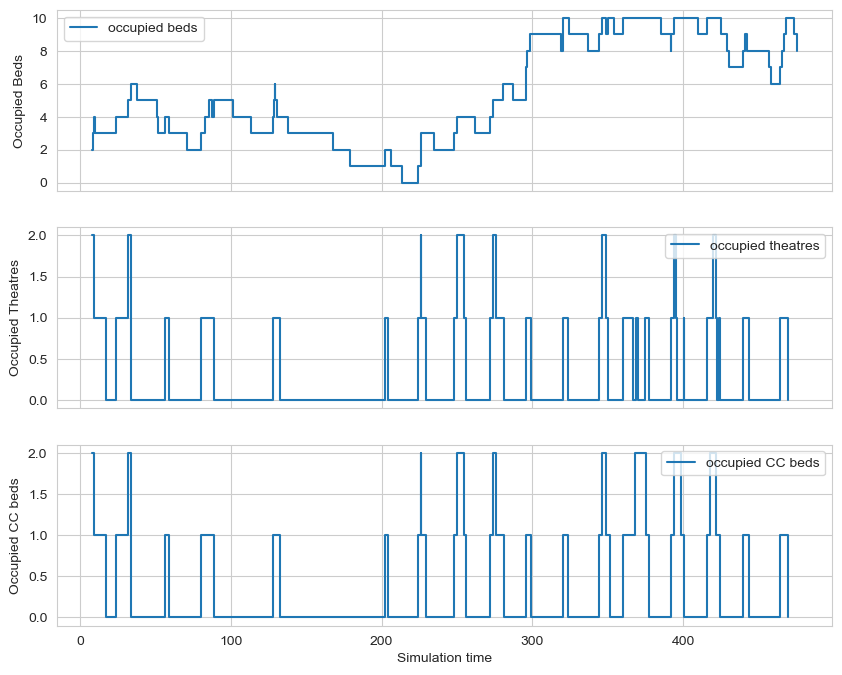

In [22]:
metrics["bed_event"].sort(key=lambda e: (e[0], e[1]))

bed_events = np.array(metrics["bed_event"])
beds = bed_events[:, 1].cumsum()
df_beds = pd.DataFrame(np.hstack([bed_events, beds.reshape((-1, 1))]), columns=["Simulation time", "Change", "Occupied beds"]).drop_duplicates(subset="Simulation time", keep='last')


metrics["surgical_event"].sort(key=lambda e: (e[0], e[1]))

surgical_event = np.array(metrics["surgical_event"])
surgeries = surgical_event[:, 1].cumsum()
df_surgery = pd.DataFrame(np.hstack([surgical_event, surgeries.reshape((-1, 1))]), columns=["Simulation time", "Change", "Occupied theatres"]).drop_duplicates(subset="Simulation time", keep='last')

metrics["cc_bed_event"].sort(key=lambda e: (e[0], e[1]))

cc_bed_events = np.array(metrics["cc_bed_event"])
cc_beds = cc_bed_events[:, 1].cumsum()
df_cc_beds = pd.DataFrame(np.hstack([cc_bed_events, cc_beds.reshape((-1, 1))]), columns=["Simulation time", "Change", "Occupied CC beds"]).drop_duplicates(subset="Simulation time", keep='last')



fig, ax = plt.subplots(3,1, sharex=True)
fig.set_figheight(8)
fig.set_figwidth(10)

sns.lineplot(df_beds, x="Simulation time", y="Occupied beds", drawstyle='steps-post', label="occupied beds", ax=ax[0])
ax[0].set_xlabel("Simulation Time")
ax[0].set_ylabel("Occupied Beds")

sns.lineplot(df_surgery, x="Simulation time", y="Occupied theatres", drawstyle='steps-post', label="occupied theatres", ax=ax[1])
ax[1].set_xlabel("Simulation Time")
ax[1].set_ylabel("Occupied Theatres")

sns.lineplot(df_cc_beds, x="Simulation time", y="Occupied CC beds", drawstyle='steps-post', label="occupied CC beds", ax=ax[2])
ax[0].set_xlabel("Simulation Time")
ax[0].set_ylabel("Occupied Beds")



In [23]:
experiment.patients

[Patient(id='Elective-3', arrival_time=0, surgical_time=8, discharge_time=9.743760135026529, surgery_duration=0.3770648214147209, recovery_time=1.366695313611809, cancellations=[]),
 Patient(id='Elective-2', arrival_time=0, surgical_time=8.37706482141472, discharge_time=50.65363375659266, surgery_duration=0.7050295937082109, recovery_time=41.57153934146973, cancellations=[]),
 Patient(id='Elective-1', arrival_time=0, surgical_time=9.082094415122931, discharge_time=51.56928592930669, surgery_duration=0.2583261196340921, recovery_time=42.228865394549665, cancellations=[]),
 Patient(id='Emergency-1', arrival_time=0, surgical_time=8, discharge_time=87.27645705372306, surgery_duration=8.767342976922162, recovery_time=70.5091140768009, cancellations=[]),
 Patient(id='Emergency1', arrival_time=9.687776406626975, surgical_time=24, discharge_time=37.406691142649954, surgery_duration=9.485234914986886, recovery_time=3.9214562276630662, cancellations=[]),
 Patient(id='Emergency2', arrival_time=27

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0, 0.5, 'Occupied Beds')

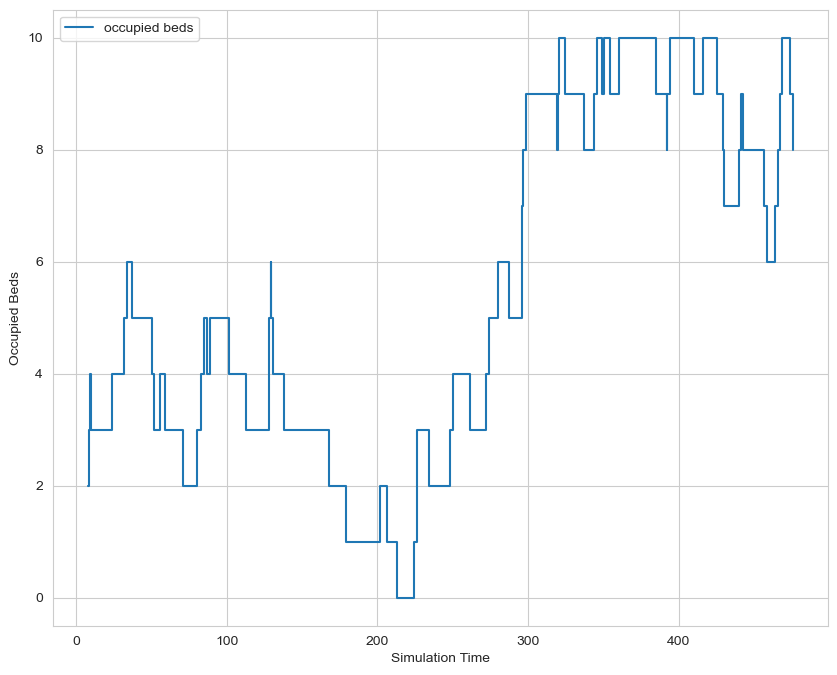

In [24]:
metrics["beds"].sort(key=lambda e: (e[0], e[1]))

bed_events = np.array(metrics["beds"])
beds = bed_events[:, 1]
df_beds = pd.DataFrame(np.hstack([bed_events, beds.reshape((-1, 1))]), columns=["Simulation time", "Change", "Occupied beds"]).drop_duplicates(subset="Simulation time", keep='last')



fig, ax = plt.subplots(1,1, sharex=True)
fig.set_figheight(8)
fig.set_figwidth(10)

sns.lineplot(df_beds, x="Simulation time", y="Occupied beds", drawstyle='steps-post', label="occupied beds", ax=ax)
ax.set_xlabel("Simulation Time")
ax.set_ylabel("Occupied Beds")

In [25]:
surgery_utilisation = (df_surgery["Simulation time"].diff() * df_surgery["Occupied theatres"].shift(1)).sum() / (RUN_LENGTH*NUM_THEATRES) * 100 # TODO: This is no longer accurate due to the new way of scheduling
bed_utilisation = (df_beds["Simulation time"].diff() * df_beds["Occupied beds"].shift(1)).sum() / (RUN_LENGTH*NUM_BEDS) * 100

surgery_utilisation, bed_utilisation

NameError: name 'NUM_THEATRES' is not defined

In [ ]:
experiment.patients

# TODO:
# - Check for metrics and scheduling in papers
# - Record patient history (DNA, hosp cancellations)
# - Separate the patient scheduling from the simulation

# - Write MORE plot code
# - 


# By next meeting:
# - Code the chance to move to CC
# - Schedule taking into account num beds too(?)
# - Schedule emergency cancellations
# - Track patient cancellations
# - Update metrics
# - Parameterise the simulation with real data
#  - Elective arrivals
#  - Surgery durations
#  - Recovery times
#  - Surgery slots per day
#  - Emergency arrivals

# - Do the layout for the report
# - Start writing the report


# Test deterministic scenarios - use real data for validation! (Trace driven simulation - look for examples in the literature)
# Test variable elective demand (what happens if there's a jump in demand) - What's the impulse response, how long before recovery
# Same for emergencies (as above)

[Patient(id='Elective-3', arrival_time=0, surgical_time=8, discharge_time=9.743760135026529, surgery_duration=0.3770648214147209, recovery_time=1.366695313611809, cancellations=[]),
 Patient(id='Elective-2', arrival_time=0, surgical_time=8.37706482141472, discharge_time=50.65363375659266, surgery_duration=0.7050295937082109, recovery_time=41.57153934146973, cancellations=[]),
 Patient(id='Elective-1', arrival_time=0, surgical_time=9.082094415122931, discharge_time=51.56928592930669, surgery_duration=0.2583261196340921, recovery_time=42.228865394549665, cancellations=[]),
 Patient(id='Emergency-1', arrival_time=0, surgical_time=24, discharge_time=106.19890471269711, surgery_duration=11.689790635896216, recovery_time=70.5091140768009, cancellations=[]),
 Patient(id='Emergency1', arrival_time=3.8751105626507902, surgical_time=197.46094997771726, discharge_time=214.0293860920295, surgery_duration=12.64697988664918, recovery_time=3.9214562276630662, cancellations=[]),
 Patient(id='Emergency

In [ ]:
# Questions:
#  What's the policy on emergency patients causing elective to be cancelled? - leave open emergency lists, 
#           ESAC List - coming out of the back of the SDU triage,
#           Same for T&O
#           Gyne has slots rather than lists
#           Each procedure is different for elective cancellation - put in max wait time for treatment function codes
#              Different for specialties
#  When scheduling occurs, are the number of beds taken into account by looking at estimated LoS of current patients?
#  Are there times of days discharges occur?
#  How do the CC beds work in terms of reserving them, or is it based on a low probability?

In [ ]:
# MONDAY: Chance to move to CC and code around that!
# MONDAY: Report structure
# TUESDAY: Get interfaces ready to prepopulate the simulation